In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
df.head(3)

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,No Positive,7.1
1,00004d18f186bf2489590dc415876f73,TV not working,No Positive,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0


In [29]:
test_df.head(3)

,review_id,negative,positive
0,00026f564b258ad5159aab07c357c4ca,Other than the location everything else was h...,Just the location
1,000278c73da08f4fcb857fcfe4ac6417,No UK TV but this was a minor point as we wer...,Great location very comfortable clean breakfa...
2,000404f843e756fe3b2a477dbefa5bd4,A tiny noisy room VERY deceptively photographed,The breakfast booked the preceding night but ...


### Text preprocessing 

In [30]:
df.loc[:, 'positive'] = df.positive.apply(lambda x: x.replace('No Positive', 'nopositive'))
df.loc[:, 'negative'] = df.negative.apply(lambda x: x.replace('No Negative', 'nonegative'))
df['review'] = df.negative + ' ' + df.positive 

test_df.loc[:, 'positive'] = test_df.positive.apply(lambda x: x.replace('No Positive', 'nopositive'))
test_df.loc[:, 'negative'] = test_df.negative.apply(lambda x: x.replace('No Negative', 'nonegative'))
test_df['review'] = test_df.negative +' '+ test_df.positive

df.head(3)

,review_id,negative,positive,score,review
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,nopositive,7.1,There were issues with the wifi connection no...
1,00004d18f186bf2489590dc415876f73,TV not working,nopositive,7.5,TV not working nopositive
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0,More pillows Beautiful room Great location L...


In [31]:
test_df.head(3)

,review_id,negative,positive,review
0,00026f564b258ad5159aab07c357c4ca,Other than the location everything else was h...,Just the location,Other than the location everything else was h...
1,000278c73da08f4fcb857fcfe4ac6417,No UK TV but this was a minor point as we wer...,Great location very comfortable clean breakfa...,No UK TV but this was a minor point as we wer...
2,000404f843e756fe3b2a477dbefa5bd4,A tiny noisy room VERY deceptively photographed,The breakfast booked the preceding night but ...,A tiny noisy room VERY deceptively photograph...


# Часть 1.
# 1 балл
Обучите логистическую регрессию на TF-IDF векторах текстов. 

In [32]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, random_state=1412) # <-для локального тестирования

x_train, y_train = df_train.review, df_train.score.values
x_test, y_test = df_test.review, df_test.score.values

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfv = TfidfVectorizer(min_df=10, analyzer='word', stop_words = 'english', 
                      lowercase=True)

In [36]:
tfv.fit(df.review)

x_train_tfv =  tfv.transform(x_train) 
x_test_tfv = tfv.transform(x_test)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
lr = LinearRegression()
lr.fit(x_train_tfv, y_train);

In [37]:
y_pred = lr.predict(x_test_tfv)

MAE = mean_absolute_error(np.round(y_pred, 1), y_test)
MAE

0.93874

#### Обучим модель на всех данных 

In [38]:
x_df = tfv.transform(df.review)
lr.fit(x_df, df.score)

x_df_predict = lr.predict(x_df)
MAE = mean_absolute_error(np.round(x_df_predict, 1), df.score)
MAE

0.8541969999999999

#### Test data

In [39]:
test_tvf = tfv.transform(test_df.review)
predict_test_score = lr.predict(test_tvf)
predict_test_score = np.round(predict_test_score, 1)
submit_df = pd.DataFrame(data = test_df.review_id)
submit_df['score'] = predict_test_score

In [40]:
submit_df.to_csv('data/output.csv', index=False)

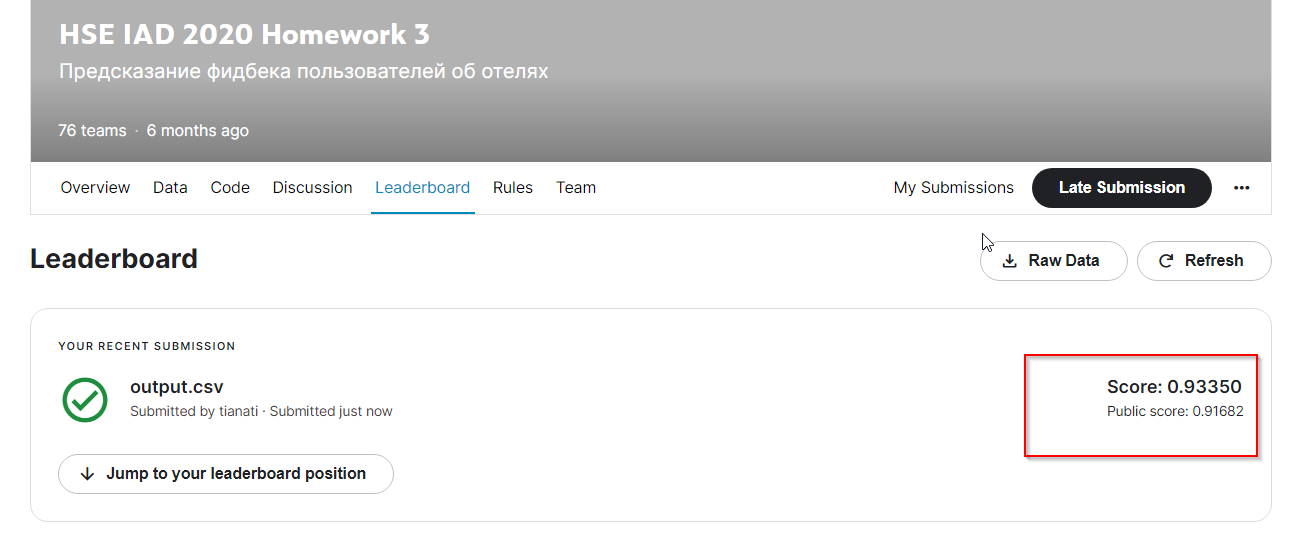

In [23]:
from IPython.display import Image
Image(filename='kaggle_1_exercise.png') 

# Часть 2. 2 балла

## 2.1 Обучите логистическую регрессию на усредненных Word2Vec векторах.

In [111]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

df.loc[:, 'positive'] = df.positive.apply(lambda x: x.replace('No Positive', 'nopositive'))
df.loc[:, 'negative'] = df.negative.apply(lambda x: x.replace('No Negative', 'nonegative'))
df['review'] = df.negative + ' ' + df.positive 
df.score = df.score

test_df.loc[:, 'positive'] = test_df.positive.apply(lambda x: x.replace('No Positive', 'nopositive'))
test_df.loc[:, 'negative'] = test_df.negative.apply(lambda x: x.replace('No Negative', 'nonegative'))
test_df['review'] = test_df.negative +' '+ test_df.positive

In [112]:
# lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

lem = WordNetLemmatizer()
# лемматизация ухудшает качество в моем случае, поэтому сделаем простой вариант препроцессинга текста

def lemmatize_text(text):
    return [w for w in word_tokenize(text.lower()) if w not in string.punctuation # lem.lemmatize(w)
            and w not in stop_words 
            and not any(i.isdigit() for i in w)
            and len(w)>1 ]

df.review = df.review.apply(lemmatize_text)
test_df.review = test_df.review.apply(lemmatize_text);

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\obars\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\obars\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
df.head(3)

,review_id,negative,positive,score,review
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,nopositive,7.1,"[issues, wifi, connection, nopositive]"
1,00004d18f186bf2489590dc415876f73,TV not working,nopositive,7.5,"[tv, working, nopositive]"
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0,"[pillows, beautiful, room, great, location, lo..."


In [6]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(w2v.popitem()[1])

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [7]:
# путем подбора были выбраны наиболее оптимальные параметры 
# (дальше будет график изменения ошибки от размера эмбеддинга):

from gensim.models import Word2Vec
model = Word2Vec(df.review, vector_size=530, window=15, min_count=8, sg=1)

model.save('word2v.model')
from gensim.models import Word2Vec
model = Word2Vec.load('word2v.model')

In [8]:
X = df.review.tolist()
y = df.score.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1412)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))
rfc_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("regression", LinearRegression())])

rfc_w2v.fit(X_train, y_train)
y_pred = rfc_w2v.predict(X_test)

MAE = mean_absolute_error(np.round(y_pred,1), y_test)
print(MAE)

0.9526818181818182


## 2.3 Изучим, как меняется ошибка на тестовой выборке при изменении параметров эмбединга

Wall time: 27min 23s


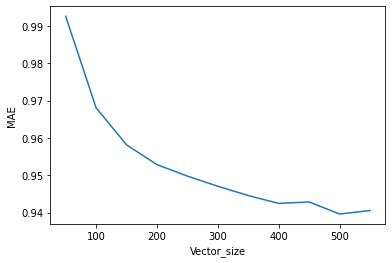

In [33]:
%%time
mae_list = []
vector_list = []
X = df.review.tolist()
y = df.score.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1412)

for vector_size in range(50, 600, 50):
    model = Word2Vec(df.review, vector_size=vector_size, window=15, min_count=8, sg=1)

    w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))
    rfc_w2v = Pipeline([
        ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
        ("regression", LinearRegression())])

    rfc_w2v.fit(X_train, y_train)
    y_pred = rfc_w2v.predict(X_test)
    MAE = mean_absolute_error(np.round(y_pred,1), y_test)
    mae_list.append(MAE)
    vector_list.append(vector_size)
plt.xlabel('Vector_size')
plt.ylabel('MAE')
plt.plot(vector_list, mae_list)

В качестве оптимального размера было выбрано значение 530

## 2.4 Обучим лучшую модель и загрузим в кэггл

 Минимальная ошибка, которой удалось добиться - это 0.94 при применении Word2Vec на всех ревью - негативных + позитивных. Этого недостаточно для выполнения критерия соревнования на кэггл. Большей точности добиться не получается при обучении на всех данных. Попробуем рассмотреть части дф отдельно. 

In [113]:
df['nonegative'] = df['negative'] == 'nonegative'
df['nopositive'] = df['positive'] == 'nopositive'
gb = df.groupby(by=['nonegative', 'nopositive'])

In [114]:
med = gb.score.median()
std = gb.score.std()
count = gb.score.count()

In [115]:
stats = pd.concat([med.rename('median'), std.rename('std'), count.rename('count')], axis=1)

In [116]:
stats

median       std  count
nonegative nopositive                         
False      False          8.8  1.629130  68204
           True           7.1  1.945611   6911
True       False          9.6  0.913345  24862
           True           8.8  1.852666     23

Предскажем score внутри группы nonegative == True как медианное значение 

In [12]:
# у нас есть маленькая группа ревью, где нет негативного комментария, и другая группа
df_triv = df[df['negative'] == 'nonegative'].copy()
df_model = df[df['negative'] != 'nonegative'].copy()

# Для отзывов, где отсутствует отрицательная часть будем предсказывать результат медианных значением
df_triv['y_pred'] = df_triv.score.median()

test_df_triv = test_df[test_df['negative'] == 'nonegative'].copy()
test_df_model = test_df[test_df['negative'] != 'nonegative'].copy()
test_df_triv['y_pred'] = df_triv.score.median()

В ходе экспериментов также попробовала заменить вычисление среднего в классе MeanEmbeddingVectorizer на сумму, так как, вероятно, повторение близких слов будет влиять на оценку отзыва. Это помогло выполнить условие kaggle - ошибка уменьшилась до приемлемой

In [13]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(w2v.popitem()[1])

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.sum([self.word2vec[w] for w in words if w in self.word2vec] # TODO: np.mean()
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [14]:
# cделаем предикт на 2 группу данных - где есть негативный комментарий
X = df_model.review.tolist()
y = df_model.score.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1412)

model = Word2Vec(df_model.review, vector_size=530, window=15, min_count=8, sg=1)

w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))
rfc_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("regression", LinearRegression())])

rfc_w2v.fit(X_train, y_train)
y_pred = rfc_w2v.predict(X_test)
df3 = pd.DataFrame(y_pred, columns=['y_pred'])
df3['score'] = y_test
df3 = df3.append(df_triv[['score', 'y_pred']], ignore_index=True)
MAE = mean_absolute_error(np.round(df3.y_pred,1), df3.score)
print(MAE)

0.8170112535985343


#### Пока что это лучший вариант, обучим последнюю модель на всей выборке для предсказания и соберем все результаты воедино (часть предсказания мы делаем медианным значением, часть линейной регрессией) и загрузим на кэггл

In [15]:
X = df.review
y = df.score

rfc_w2v.fit(X, y)
test_df_model['y_pred'] = rfc_w2v.predict(test_df_model.review)

df_result = test_df_model[['review_id', 'y_pred']]
df_result = df_result.append(test_df_triv[['review_id', 'y_pred']], ignore_index=True)
df_result.rename(columns={'y_pred':'score'}, inplace=True)
df_result.head(3)

,review_id,score
0,00026f564b258ad5159aab07c357c4ca,7.113703
1,000278c73da08f4fcb857fcfe4ac6417,10.129708
2,000404f843e756fe3b2a477dbefa5bd4,7.585840


In [137]:
df_result.to_csv('data/output_vec.csv', index=False)

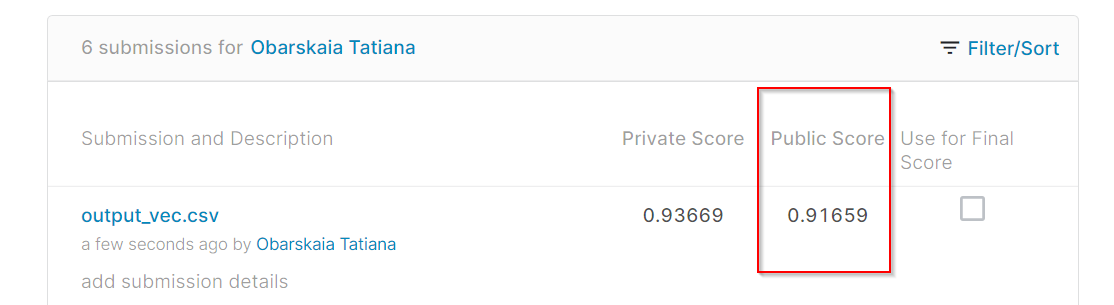

In [16]:
from IPython.display import Image
Image(filename='output_vec_exercise2.png')

## 2.2 TF-iDF

In [18]:
# воспользуемся классом
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(w2v.popitem()[1])

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0) for words in X
            ])

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

rfc_w2v = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("lr", LinearRegression())])

In [24]:
X = df.review.tolist()
y = df.score.tolist()
model = Word2Vec(df.review, vector_size=530, window=15, min_count=8, sg=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1412)
rfc_w2v.fit(X_train, y_train)
y_pred = rfc_w2v.predict(X_test)

MAE = mean_absolute_error(np.round(y_pred,1), y_test)

In [27]:
print(MAE)

0.9688212121212122


## 2.3 Посмотрим, как меняется ошибка в случае с tf-idf в зависимости от размера эмбеддинга

In [39]:
%%time
mae_list = []
vector_list = []
X = df.review.tolist()
y = df.score.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1412)

for vector_size in range(100, 600, 50):
    model = Word2Vec(df.review, vector_size=vector_size, window=15, min_count=8, sg=1)

    w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))
    rfc_w2v = Pipeline([
        ("tfidf vectorizer", TfidfEmbeddingVectorizer(w2v)),
        ("regression", LinearRegression())])

    rfc_w2v.fit(X_train, y_train)
    y_pred = rfc_w2v.predict(X_test)
    MAE = mean_absolute_error(np.round(y_pred,1), y_test)
    mae_list.append(MAE)
    vector_list.append(vector_size)

Wall time: 30min 45s


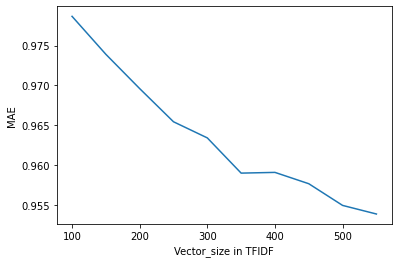

In [40]:
plt.xlabel('Vector_size in TFIDF')
plt.ylabel('MAE')
plt.plot(vector_list, mae_list)

### Выводы:
TF-idf весами с тем же самым размером эмбеддинга модель имеет качество хуже. Вероятно, это происходит за счет того, что слова типа "хороший", "плохой" встречаются практически в каждом отзыве и теряют свою значимость в таком методе оценки. 

### Попробуем другой эмбеддинг, glove-wiki-gigaword-300

In [32]:
### glove_vectors
import gensim.downloader
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')  
size = glove_vectors['cat'].size

def words_list_to_vec(words_list, model):
    vectors = []
    for i in words_list:
        if i in model:
            vectors.append(model[i])
    if len(vectors) == 0:
        return np.zeros(size)
    arr = np.array(vectors)
    return np.mean(arr, axis=0)

df['numeric'] = df.review.apply(words_list_to_vec, model=glove_vectors)
df_vector = pd.DataFrame(df['numeric'].to_list(), columns=list(range(300)))
df_vector['score'] = df.score

num_columns = list(df_vector.columns)[:-1]

X = df_vector[num_columns]
y = df_vector['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1412) # <-для локального тестирования
print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

MAE = mean_absolute_error(np.round(y_pred, 1), y_test)
print('MAE', MAE)

total train examples 75000
total test examples 25000
MAE 1.0484280000000001


### Выводы:
С готовым эмбеддингом не получилось добиться хорошего результата. Возможно, выбрала не подходящий, так как эмбеддинг, обученный на википедии может просто плохо описывать то, что происходит в реальных отзывах, так как заточен на работу с научным стилем текста. Также время работы алгоритма увеличилось.
#### Итог:
Моделью линейной регрессии не получилось добиться нужного результата "в лоб". Предобработка отзывов значительно помогла улучшить качество линейной регрессии, но лемматизация ревью только ухудшила результат (в итоге от нее пришлось отказаться), хотя, казалось, она должна  оставить только важную часть данных. Добиться нужного качества получилось только путем отдельного рассмотрения разных групп отзывов.

## Часть 3. 4 балла

Обучите RNN/Transformer для предсказания пользовательской оценки. Получите ошибку меньше, чем во всех вышеперечисленных методах.

Это задание выполнить не получилось, к сожалению, но вся предобработка датафрейма была выполнена

In [126]:
import numpy as np
import pandas as pd

df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

df.loc[:, 'positive'] = df.positive.apply(lambda x: x.replace('No Positive', 'nopositive'))
df.loc[:, 'negative'] = df.negative.apply(lambda x: x.replace('No Negative', 'nonegative'))
df['review'] = df.negative + ' ' + df.positive 

test_df.loc[:, 'positive'] = test_df.positive.apply(lambda x: x.replace('No Positive', 'nopositive'))
test_df.loc[:, 'negative'] = test_df.negative.apply(lambda x: x.replace('No Negative', 'nonegative'))
test_df['review'] = test_df.negative +' '+ test_df.positive

In [127]:
# lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

lem = WordNetLemmatizer()
#лемматизация ухудшает качество в моем случае, поэтому сделаем простой вариант препроцессинга текста

def lemmatize_text(text):
    return [w for w in word_tokenize(text.lower()) if w not in string.punctuation 
            # lem.lemmatize(w)
            and w not in stop_words 
            and not any(i.isdigit() for i in w)
            and len(w)>1 ]

df.review = df.review.apply(lemmatize_text)
test_df.review = test_df.review.apply(lemmatize_text);

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\obars\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\obars\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [128]:
words = set()
for sent in list(df['review']):
    for word in sent:
        words.add(word)      
int2word = dict(enumerate(tuple(words), start=1))
word2int = {w: ii for ii, w in int2word.items()}

max_len = max(df['review'].apply(len))
mean_len = df['review'].apply(len).mean()
smallest_len = df['review'].apply(len).min()

print(len(words) == len(int2word) == len(word2int))
print(f'В словаре всего {len(words)} слов')
max_len, mean_len, smallest_len

True
В словаре всего 32754 слов


(321, 18.47719, 0)

In [129]:
# У нас также есть отзывы нулевой длины
print('Count of 0 len reviews: ', df[df['review'].apply(len) == 0].count()[0])
print(len(df))
df = df.drop(index=df[df['review'].apply(len) == 0].index.values.tolist())
print('When we drop 0 len reviews:', len(df))

Count of 0 len reviews:  19
100000
When we drop 0 len reviews: 99981


In [130]:
import torch
from torch.nn.utils.rnn import pad_sequence

train_pos_pad = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:max_len]) for seq in df['review']], 
                           batch_first=True)

In [131]:
train_pos_pad[0]

tensor([29787, 29713,  6357, 18572,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [134]:
from sklearn.model_selection import train_test_split
X = train_pos_pad
y = df.score.values / 10 # TODO

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1412) # <-для локального тестирования
print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

total train examples 74985
total test examples 24996


In [135]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
batch_size = 50

train_dataset = TensorDataset(X_train, torch.from_numpy(y_train))
test_dataset = TensorDataset(X_test, torch.from_numpy(y_test))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [136]:
dataiter = iter(train_dataloader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample score size: ', sample_y.size()) # batch_size
print('Sample score: \n', sample_y)

Sample input size:  torch.Size([50, 321])
Sample input: 
 tensor([[ 5821, 22687, 22529,  ...,     0,     0,     0],
        [  525,  4807,   525,  ...,     0,     0,     0],
        [18152,  1033, 14041,  ...,     0,     0,     0],
        ...,
        [22891, 27825, 19956,  ...,     0,     0,     0],
        [  242,  5439,  4320,  ...,     0,     0,     0],
        [23313, 18308, 19198,  ...,     0,     0,     0]])

Sample score size:  torch.Size([50])
Sample score: 
 tensor([0.7500, 1.0000, 1.0000, 0.4600, 0.7100, 1.0000, 0.7500, 0.9600, 0.9600,
        0.7500, 0.9600, 0.7900, 1.0000, 0.9200, 0.5800, 0.5000, 0.9200, 0.9200,
        0.7500, 0.7500, 0.5000, 0.8800, 0.9600, 0.8800, 0.8800, 0.9200, 0.8800,
        1.0000, 0.9200, 1.0000, 0.7500, 0.9600, 0.5400, 0.5400, 1.0000, 0.7100,
        0.4200, 0.8800, 0.4200, 0.9200, 1.0000, 0.8300, 0.9200, 1.0000, 0.9200,
        0.8800, 0.8300, 0.9200, 0.9600, 0.9200], dtype=torch.float64)


In [137]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()
if(train_on_gpu):
    device = torch.device("cuda")
    print('Training on GPU.')
else:
    device = torch.device("cpu")
    print('No GPU available, training on CPU.')

Training on GPU.


In [138]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentRNN, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)
        
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)
        
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = self.sig(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]  # TODO * 10
        return sig_out, hidden 
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        if(train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden

In [139]:
vocab_size = len(word2int) + 1
output_size = 1
embedding_dim = 400 
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
#net.to(device)
print(net)

SentimentRNN(
  (embedding): Embedding(32755, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [140]:
lr=0.01
criterion = nn.L1Loss() 
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [141]:
epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing
counter = 0
print_every = 100
clip=5 # gradient clipping

if(train_on_gpu):
    net.cuda()


for e in range(epochs):
    net.train()
    h = net.init_hidden(batch_size)
    train_losses = []
    for inputs, labels in train_dataloader:
        labels = labels.float()
        #counter += 1 TODO

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        h = tuple([each.data for each in h])
        net.zero_grad()

        output, h = net(inputs, h)
        loss = criterion(output.reshape(-1, 50), labels.reshape(-1, 50))
        loss.backward()
        train_losses.append(loss.item())
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
    if True:
        val_h = net.init_hidden(batch_size)
        val_losses = []
        net.eval()
        for inputs, labels in test_dataloader:
            val_h = tuple([each.data for each in val_h])
            if(train_on_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()
            output, val_h = net(inputs, val_h)
            val_loss = criterion(output.reshape(-1, 50), labels.reshape(-1, 50))
            val_losses.append(val_loss.item())

        net.train()
        print("Epoch: {}/{}...".format(e+1, epochs),
              #"Step: {}...".format(counter),
              "Loss: {:.6f}...".format(np.mean(train_losses)),
              "Val Loss: {:.6f}".format(np.mean(val_losses)))

KeyboardInterrupt: 